In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.cluster import KMeans
import pickle


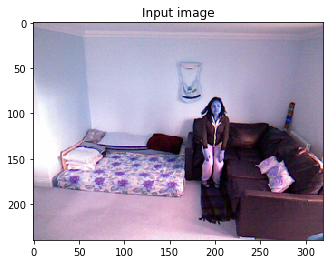

In [4]:
main_folder=r"D:\BTech\Dataset"
m=os.listdir(main_folder)
path=os.path.join(main_folder,m[3])
filename=os.listdir(path)[300]
p=os.path.join(path,filename)

img = cv2.imread(p)

plt.title('Input image')
plt.imshow(img); plt.show()

[[103  37 226 ... 246 246 198]
 [200 211 189 ... 163   5 115]
 [236 168 152 ... 171  78 138]
 ...
 [ 55 112  99 ...  63 122 214]
 [184 217 106 ... 187 124 240]
 [ 61  29 106 ... 139 122 162]]
(457, 32)


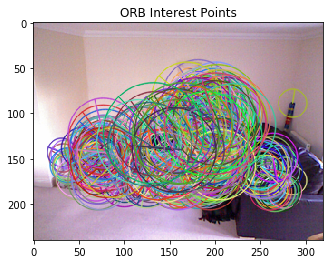

In [5]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from cv's BRG default color order to RGB

orb = cv2.ORB_create()  # OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.
key_points, description = orb.detectAndCompute(img, None)
img_keypoints = cv2.drawKeypoints(img,key_points,img, 
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
print(description)
print(description.shape)


plt.title('ORB Interest Points')
plt.imshow(img); plt.show()

## Feature Extraction

In [95]:
main_folder=r"D:\BTech\Dataset"

for folder in os.listdir(main_folder):
    path=os.path.join(main_folder,folder)
    for filename in os.listdir(path):
        p=os.path.join(path,filename)
        a=cv2.imread(p)
        resize=(300,300)
        img=cv2.resize(a,resize)#resize image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        orb = cv2.ORB_create()#initialise  detector
        keypoints, descriptors = orb.detectAndCompute(gray, None)
        out=pd.DataFrame(descriptors)
        csv_data=out.to_csv(str(folder)+'_cp_exp.csv', mode='a', header=False)
    print('Extraction of ' + str(folder) +' images Done!')  

Extraction of No_person images Done!
Extraction of Sitting_person images Done!
Extraction of Sleeping_person images Done!
Extraction of Standing_person images Done!


In [96]:
from csv import writer
from csv import reader

main_folder=r"D:\BTech\Dataset"
for folder in os.listdir(main_folder):
    with open(str(folder)+'_cp_exp.csv', 'r') as read_obj, \
        open('withoutkmeans_exp.csv', 'a+', newline='') as write_obj:
        csv_reader = reader(read_obj)     # Create a csv.reader object from the input file object
        csv_writer = writer(write_obj)    # Create a csv.writer object from the output file object
        for row in csv_reader:
                csv_writer.writerow(row)      # Add the updated row / list to the output file


## WCSS

In [4]:
Sum_of_squared_distances = []
road_df=pd.read_csv('withoutkmeans_exp.csv').iloc[:, 1:]
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(road_df)
    Sum_of_squared_distances.append(km.inertia_)

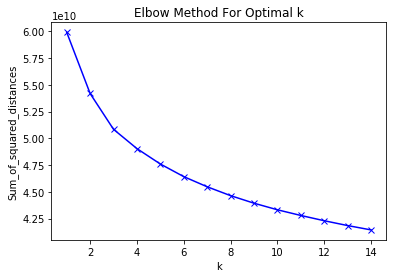

In [71]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## KMeans

In [2]:
import pickle
data=pd.read_csv('withoutkmeans_exp.csv').iloc[:, 1:]
kmeans = KMeans(n_clusters=8)
model=kmeans.fit(data)
print(model)
pickle.dump(model, open('kmeansmodel.pkl', 'wb')) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [13]:
#print(data)

In [15]:
label = kmeans.fit_predict(data)
filtered_label0 = data[label == 0]

#print(filtered_label0)

In [98]:
main_folder=r"D:\BTech\Dataset"

for folder in os.listdir(main_folder):
    model = pickle.load(open('kmeansmodel.pkl', "rb"))
    path=os.path.join(main_folder,folder)
    for filename in os.listdir(path):
        p=os.path.join(path,filename)
        a=cv2.imread(p)
        resize=(300,300)
        img=cv2.resize(a,resize)#resize image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        orb = cv2.ORB_create()#initialise  detector
        keypoints, descriptors = orb.detectAndCompute(gray, None)
        out=pd.DataFrame(descriptors)
        
        output=pd.DataFrame(model.predict(out))
        hist=np.histogram(output.values,bins=[0,1,2,3,4,5,6,7,8])
        histout=pd.DataFrame(hist[0])
        
        csv_data=histout.transpose().to_csv(str(folder)+'_1_exp'+'.csv', mode='a', header=False)
        
    print('KMeans of ' + str(folder) +' images Done!')

KMeans of No_person images Done!
KMeans of Sitting_person images Done!
KMeans of Sleeping_person images Done!
KMeans of Standing_person images Done!


## Labelling

In [17]:
from csv import writer
from csv import reader

main_folder=r"D:\BTech\Dataset"
classes=['No Peson','Sitting','Sleeping','Standing']
i=0
for folder in os.listdir(main_folder):
    with open(str(folder)+'_1_exp'+'.csv', 'r') as read_obj, \
        open('Final_ORB_kmeans_exp.csv', 'a+', newline='') as write_obj:
        csv_reader = reader(read_obj)     # Create a csv.reader object from the input file object
        csv_writer = writer(write_obj)    # Create a csv.writer object from the output file object
        # Read each row of the input csv file as list
        for row in csv_reader:
            row.append(classes[i])            # Append the class in the row / list
            csv_writer.writerow(row)      # Add the updated row / list to the output file
    i+=1
    

In [2]:
dataset = pd.read_csv('Final_ORB_kmeans_exp.csv')
X = dataset.iloc[:, 1:9].values
y = dataset.iloc[:, 9].values
print(X.shape)
print(y.shape)

(1532, 8)
(1532,)


## Splitting Data

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


## Classification

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=160)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
#print(y_pred)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[ 40   0   0   1]
 [  0 111  16  11]
 [  0   5 136   3]
 [  1   7  11 118]]
             precision    recall  f1-score   support

   No Peson       0.98      0.98      0.98        41
    Sitting       0.90      0.80      0.85       138
   Sleeping       0.83      0.94      0.89       144
   Standing       0.89      0.86      0.87       137

avg / total       0.88      0.88      0.88       460

Accuracy: 0.8804347826086957


## SVM

In [24]:
from sklearn.svm import SVC
svm =  SVC()
svm.fit(X_train, y_train)
y_pred=svm.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
y_pred=svm.predict(X_test)

from sklearn import metrics
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[ 34   0   0   7]
 [  0 112  12  14]
 [  0   9 130   5]
 [  2   6  14 115]]
             precision    recall  f1-score   support

   No Peson       0.94      0.83      0.88        41
    Sitting       0.88      0.81      0.85       138
   Sleeping       0.83      0.90      0.87       144
   Standing       0.82      0.84      0.83       137

avg / total       0.85      0.85      0.85       460

Accuracy: 0.85


## KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
y_pred=svm.predict(X_test)

from sklearn import metrics
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[ 41   0   0   0]
 [  0 112  19   7]
 [  0   3 138   3]
 [  2   6  13 116]]
             precision    recall  f1-score   support

   No Peson       0.95      1.00      0.98        41
    Sitting       0.93      0.81      0.86       138
   Sleeping       0.81      0.96      0.88       144
   Standing       0.92      0.85      0.88       137

avg / total       0.89      0.88      0.88       460

Accuracy: 0.85


In [26]:
from sklearn import metrics
est=range(20,200,20)
acc_score=[]
err=[]
for n in est:
    clf=RandomForestClassifier(n_estimators=n)
    clf.fit(X_train,y_train)
    score=metrics.accuracy_score(y_test, y_pred)
    acc_score.append(score)
    pred_i = clf.predict(X_test)
    err.append(np.mean(pred_i != y_test))

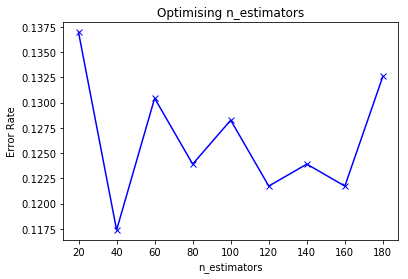

In [27]:
plt.plot(est, err, 'bx-')
plt.xlabel('n_estimators')
plt.ylabel('Error Rate')
plt.title('Optimising n_estimators')
plt.show()

## Saving Classifier

In [28]:
filename = 'finalized_model1.sav'
pickle.dump(clf, open(filename, 'wb'))

## Classification Trial

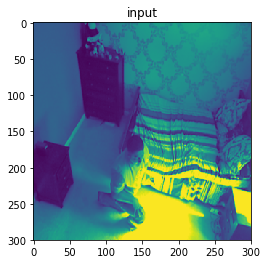

In [29]:
model = pickle.load(open('kmeansmodel.pkl', "rb"))
main_folder=r"D:\BTech\Dataset\Standing_person"

p=os.path.join(main_folder,'rgb_1357.png')
a=cv2.imread(p)
resize=(300,300)
img=cv2.resize(a,resize)#resize image
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(gray)
plt.title('input')
plt.show()

orb = cv2.ORB_create()#initialise  detector
keypoints, descriptors = orb.detectAndCompute(gray, None)
out=pd.DataFrame(descriptors)
        
output=pd.DataFrame(model.predict(out))
hist=np.histogram(output.values,bins=[0,1,2,3,4,5,6,7,8])
histout=pd.DataFrame(hist[0])

In [30]:
m=[]
m.append(hist[0])
loaded_model = pickle.load(open(filename, 'rb'))
output=pd.DataFrame(m)
print(output)
x1 = output.iloc[:, 0:9]

prediction=loaded_model.predict(x1)
print(prediction)

    0   1   2   3   4   5   6   7
0  83  86  34  72  70  41  54  43
['Standing']


In [31]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

In [32]:
print(result)

0.8673913043478261
